In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/birds-525'):
    for filename in filenames:
        print('')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Section 1 : Data PreProcessing

Check if GPU is Available

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected device:", device)

if device.type == "cuda":
    gpu_index = 0
    print("Selected GPU:", torch.cuda.get_device_name(gpu_index))
    torch.cuda.set_device(gpu_index)

Selected device: cuda
Selected GPU: NVIDIA RTX 6000 Ada Generation


SECTION 1.1 : Seting Up DataFrames

Train Data

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn import preprocessing
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D,TimeDistributed,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout,GlobalMaxPooling2D,Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-23 02:37:11.682103: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 02:37:11.740424: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Path Variables

In [4]:
train_dir = "/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/birds-525/train"
test_dir = "/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/birds-525/test"
val_dir = "/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/birds-525/valid"

# train_dir = "/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/data/train"
# test_dir = "/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/data/test"
# val_dir = "/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/data/valid"


Model for RNN(specificaly LSTM)

fit data generator

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf


class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, target_size, number_of_frames, data_gen=None):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.number_of_frames = number_of_frames
        self.data_gen = data_gen  # ImageDataGenerator instance for augmentation

        # Assuming you have other initialization code
        self.df = self.load_data_from_directory()
        self.bird_to_label = {bird_name: label_index for label_index,
                              bird_name in enumerate(sorted(set(self.df['label'])))}

    def load_data_from_directory(self):
        paths = []
        labels = []
        for bird_type in os.listdir(self.directory):
            cur_path = os.path.join(self.directory, bird_type)
            path_data = os.listdir(cur_path)
            paths.extend([os.path.join(cur_path, img) for img in path_data])
            labels.extend([bird_type] * len(path_data))
        df = pd.DataFrame({"path": paths, "label": labels})
        return df

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        # Calculate the actual index by modulo operation with the dataset size
        # This makes the index loop back to 0 once it reaches the end of the dataset
        actual_index = index % len(self)

        batch_df = self.df[actual_index *
                        self.batch_size: (actual_index + 1) * self.batch_size]
        X, y = self.process_data(batch_df)
        return X, y

    def process_data(self, batch_df):
        X = []
        y = []
        for _, row in batch_df.iterrows():
            frames = []
            label = row['label']
            img_path = row['path']
            # For each frame, we now apply the augmentation here
            for frame in range(1, self.number_of_frames + 1):
                img = tf.keras.preprocessing.image.load_img(
                    img_path, target_size=self.target_size, color_mode='grayscale')
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = img_array / 255.0  # Normalize pixel values

                if self.data_gen:
                    # Apply the augmentation here
                    img_array = self.data_gen.random_transform(img_array)
                    # Ensure the transformation is applied
                    img_array = self.data_gen.standardize(img_array)

                resized_img = tf.image.resize(img_array, self.target_size)
                frames.append(resized_img)
            X.append(frames)

            # Convert bird names to integer labels and apply one-hot encoding
            label_int = self.bird_to_label.get(label)
            if label_int is not None:
                y.append(tf.keras.utils.to_categorical(
                    label_int, num_classes=len(self.bird_to_label)))
            else:
                print(f"Invalid label: {label}")
        return np.array(X), np.array(y)


# Initialize your ImageDataGenerator with the desired augmentations
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Pass this ImageDataGenerator instance to your CustomDataGenerator
train_generator = CustomDataGenerator(train_dir, target_size=(
    126, 126), batch_size=16, number_of_frames=10, data_gen=data_gen)
val_generator = CustomDataGenerator(val_dir, target_size=(
    126, 126), batch_size=16, number_of_frames=10, data_gen=data_gen)
test_generator = CustomDataGenerator(test_dir, target_size=(
    126, 126), batch_size=16, number_of_frames=10, data_gen=data_gen)


In [6]:
modelRNN = Sequential()

# Assuming we want to manually set the first Conv2D layer to emphasize edge detection
# This is a simplistic approach; in practice, the layer should learn this from data.
edge_detection_kernel = np.array([[[[-1]], [[-1]], [[-1]]],
                                  [[[-1]], [[8]], [[-1]]],
                                  [[[-1]], [[-1]], [[-1]]]])

modelRNN.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', kernel_initializer=lambda shape, dtype=None: edge_detection_kernel),
                             input_shape=(None, 126, 126, 1)))
modelRNN.add(TimeDistributed(MaxPooling2D((2, 2))))
modelRNN.add(TimeDistributed(BatchNormalization()))

# Continuing with the original architecture
modelRNN.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
modelRNN.add(TimeDistributed(MaxPooling2D((2, 2))))
modelRNN.add(TimeDistributed(BatchNormalization()))
modelRNN.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
modelRNN.add(TimeDistributed(MaxPooling2D((2, 2))))
modelRNN.add(TimeDistributed(BatchNormalization()))
modelRNN.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
modelRNN.add(TimeDistributed(MaxPooling2D((2, 2))))
modelRNN.add(TimeDistributed(BatchNormalization()))
modelRNN.add(TimeDistributed(Flatten()))

# Adding an additional LSTM layer
modelRNN.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
modelRNN.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

modelRNN.add(Dense(128, activation='relu'))
modelRNN.add(Dropout(0.5))
modelRNN.add(Dense(525, activation='softmax'))


/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-04-23 02:38:00.140979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 414 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:4f:00.0, compute capability: 8.9
2024-04-23 02:38:00.146655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22215 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:52:00.0, compute capability: 8.9
2024-04-23 02:38:00.150936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/

In [ ]:
modelRNN = Sequential()

modelRNN.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'),
             input_shape=(None, 126, 126, 1)))
modelRNN.add(TimeDistributed(MaxPooling2D((2, 2))))
modelRNN.add(TimeDistributed(BatchNormalization()))
modelRNN.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
modelRNN.add(TimeDistributed(MaxPooling2D((2, 2))))
modelRNN.add(TimeDistributed(BatchNormalization()))
modelRNN.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
modelRNN.add(TimeDistributed(MaxPooling2D((2, 2))))
modelRNN.add(TimeDistributed(BatchNormalization()))
modelRNN.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
modelRNN.add(TimeDistributed(MaxPooling2D((2, 2))))
modelRNN.add(TimeDistributed(BatchNormalization()))
modelRNN.add(TimeDistributed(Flatten()))

modelRNN.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

modelRNN.add(Dense(128, activation='relu'))
modelRNN.add(Dropout(0.5))
# Adjust the number of units to match the number of classes
modelRNN.add(Dense(525, activation='softmax'))


Compilation for RNN

In [7]:
print("validation_steps",len(val_generator))
print("steps per epoch", len(train_generator))

validation_steps 165
steps per epoch 5290


In [8]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)


In [13]:
from tensorflow.keras import metrics

# Compile the model
modelRNN.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=[
                 'accuracy', metrics.Precision(), metrics.Recall()])

# Train the model using fit_generator
model = modelRNN.fit(train_generator,
        #   steps_per_epoch = 2,
           epochs=2,
           batch_size=90,
           validation_data =val_generator,
           callbacks=[tensorboard_callback]
        #   validation_steps = int(len(val_generator))
        )

Epoch 1/2


2024-04-23 04:13:25.163683: W external/local_tsl/tsl/framework/bfc_allocator.cc:487] Allocator (GPU_0_bfc) ran out of memory trying to allocate 30.03MiB (rounded to 31490048)requested by op StatefulPartitionedCall/sequential_1/time_distributed_1/Relu_7-0-1-TransposeNCHWToNHWC-LayoutOptimizer
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-23 04:13:25.163769: I external/local_tsl/tsl/framework/bfc_allocator.cc:1044] BFCAllocator dump for GPU_0_bfc
2024-04-23 04:13:25.163808: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (256): 	Total Chunks: 215, Chunks in use: 212. 53.8KiB allocated for chunks. 53.0KiB in use in bin. 4.4KiB client-requested in use in bin.
2024-04-23 04:13:25.163828: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (512): 	Total Chunks: 18, Chunks in use: 17. 9.2KiB allocated fo

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall/sequential_1/time_distributed_1/Relu_7-0-1-TransposeNCHWToNHWC-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[16,124,124,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node StatefulPartitionedCall/sequential_1/time_distributed_1/Relu_7-0-1-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_136979]

Compilation for model0

In [35]:
modelRNN.save(
    '/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/modelRNN.h5')
modelRNN.save('my_model.h5')
modelRNN.save_weights('modelRNN.weights.h5')

/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/lib/python3.10/site-packages/keras/src/initializers/__init__.py:60: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: modelRNN.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', kernel_initializer=lambda shape, dtype=None: edge_detection_kernel),
                             input_shape=(None, 126, 126, 1)))

  return serialization_lib.serialize_keras_object(initializer)


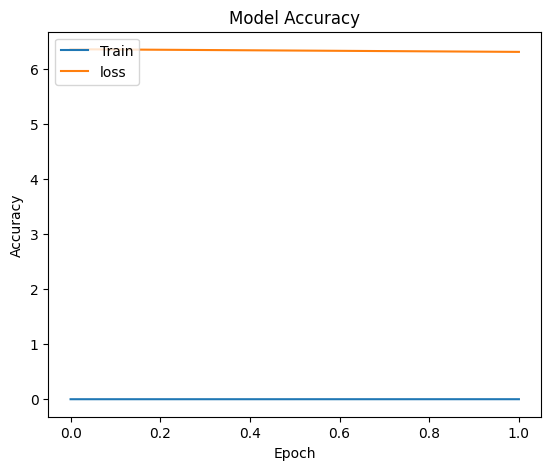

In [36]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(model.history['accuracy'])
plt.plot(model.history['loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'loss'], loc='upper left')

plt.show()


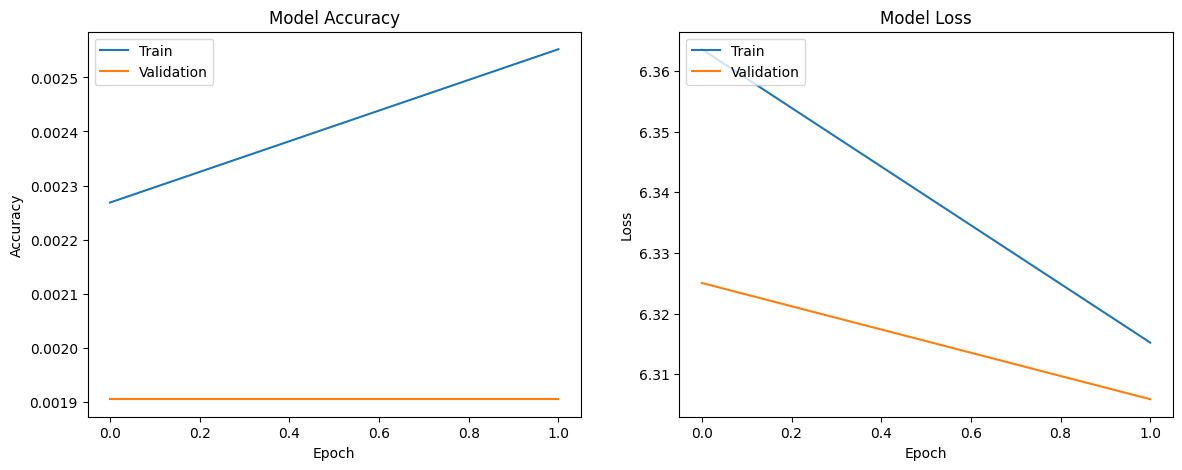

In [37]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [41]:
from sklearn.metrics import classification_report

# Initialize empty lists to hold predictions and true labels
all_preds = []
all_true_labels = []

print("len Test", len(test_generator))

# Manually iterate over the test generator
for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    preds = modelRNN.predict_on_batch(X_batch)

    # Store batch predictions and labels
    all_preds.extend(np.argmax(preds, axis=1))
    all_true_labels.extend(np.argmax(y_batch, axis=1))

# Convert lists to arrays for evaluation
all_preds = np.array(all_preds)
print("all_preds",all_preds)
all_true_labels = np.array(all_true_labels)
print("all_true_labels", all_true_labels)

# Print the evaluation report
print(classification_report(all_true_labels, all_preds))

len Test 165
all_preds [434 434 434 ... 434 434 434]
all_true_labels [  3   3   3 ... 523 523 523]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         5
          15       0.00      0.00   

/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

Activation Map testing

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras import Sequential

# Define your model architecture here
modelRNN = Sequential()

# Assuming the first Conv2D layer is set for edge detection as you've defined
edge_detection_kernel = np.array([[[[-1]], [[-1]], [[-1]]],
                                  [[[-1]], [[8]], [[-1]]],
                                  [[[-1]], [[-1]], [[-1]]]])

modelRNN.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', kernel_initializer=lambda shape, dtype=None: edge_detection_kernel),
                             input_shape=(None, 126, 126, 1)))
# Continuing with the rest of your model architecture...

# Create a new model that outputs activations from specific layers
# Here, we're interested in the last Conv2D layer and the last LSTM layer
model_for_activations = Model(inputs=modelRNN.input,
                              outputs=[modelRNN.layers[-5].output,  # This should point to the last Conv2D layer
                                       modelRNN.layers[-3].output])  # This should point to the last LSTM layer

# Assuming `input_sequence` is your input data that matches the model's expected input shape
input_sequence = ...  # Make sure to define your input_sequence

# Get activations
activations = model_for_activations.predict(test_dir)

# Assuming we have the activations, let's visualize the activations of the last LSTM layer
# Note: Visualizing the Conv2D activations would require a different approach
lstm_activations = activations[1]  # If LSTM layer is the second in the outputs list

# Select the first example in the batch and visualize the activations across all timesteps for the first LSTM unit
plt.matshow(lstm_activations[0, :, 0].T, cmap='viridis')
plt.xlabel('Timestep')
plt.ylabel('Activation of the first LSTM unit')
plt.title('LSTM Layer Activations over Time')
plt.colorbar()
plt.show()

# Please note that `input_sequence` needs to be defined with your actual data.
# Additionally, the visualization code for LSTM activations is commented out because it requires actual LSTM activation data.
# For Conv2D activations, consider visualizing specific filters' activations across different input images to understand what features they are learning.


/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: The layer sequential_1 has never been called and thus has no defined input.